# Lagermann Data - Reactant s0 - kinetic Modeling with ODE Solver

### Imports
Import packages and set global varibales used in this notebook

In [1]:
import os # operating system to work with directories and files
import matplotlib.pyplot as plt # plot data and results
import seaborn as sns # prettier visualization
import pandas as pd # convert excel to dataframe
import numpy as np # convert dataframe to nparray for solver

from scipy.integrate import odeint # solve ode
from lmfit import minimize, Parameters, Parameter, report_fit # fitting

from pyenzyme import EnzymeMLDocument # EnzymeML document functionalities

sns.set(style="whitegrid")

## Select EnzymeML document
Select the EnzymeML document created with BioCatHub, by changing the path vriable accodingly. <br>
The whole EnzymeML document is stored in the enzmldoc varible. <br>
Prints a short overview.

In [2]:
enzmldoc = EnzymeMLDocument.fromFile('EnzymeML_Lagerman.omex')

## Visualization of timecourse data
A short visualisation to get a first impression of the data. <br>

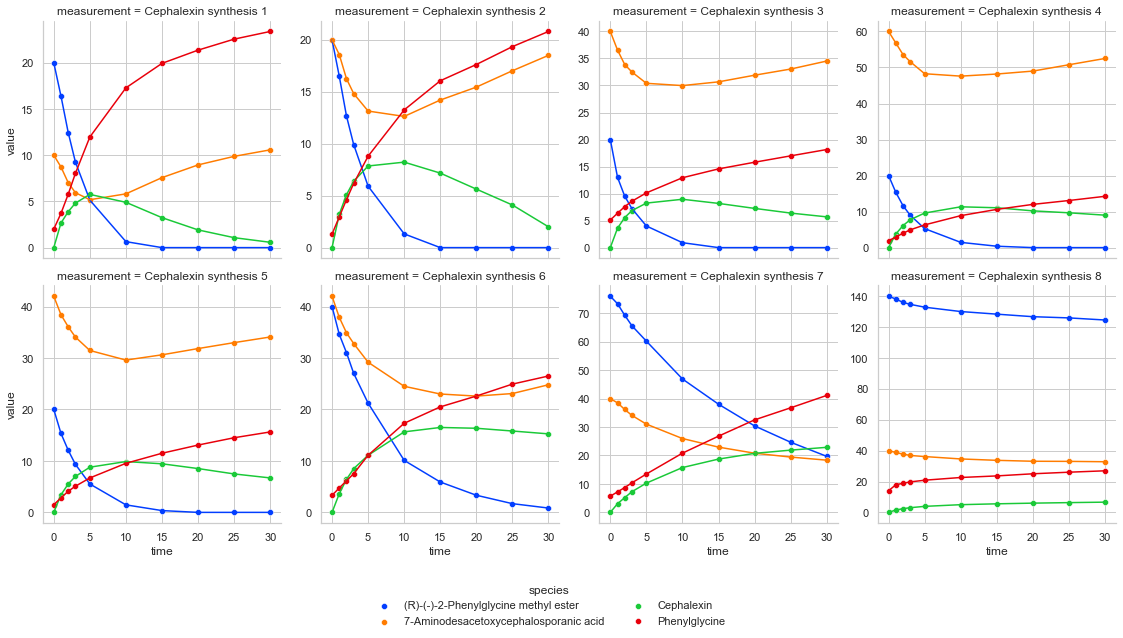

In [3]:
#basic/general settings for Seaborn
sns.set_theme(style="whitegrid", palette ='bright',color_codes=True, context = 'notebook')

enzmldoc.visualize(sharey=False, use_names=True, height=4)

## Parameter Estimation and Modeling
#### Data preparation
Convert pandas dataframe from EnzymeML data to numpy arrays. <br>
First select the reactant to model by changing the reactant_id accordingly, see overview above for selction options.<br>
In this example substrate 's0' will be modeled.<br>
##### Choose against which timecourse you want to fit.

In [15]:
reactant_id = 's0'
data = enzmldoc.exportMeasurementData(species_ids=reactant_id)

# Concentenate data to a single DataFram
data = pd.concat([meas["data"] for meas in data.values()])

# Separate time and actual values to ndarrays
# Reshape to match 8 measurements with 10 points each
data_time = data.time.values.reshape(10, -1)
data_s = data["s0"].values.reshape(10, -1)

("Shape data/time", data_s.shape, data_time.shape)

('Shape data/time', (10, 8), (10, 8))

### Fit data to a system of ODEs
#### Define the ODE functions

In [5]:
def f_old(w, t, params):
    '''
    System of differential equations
    Arguments:
        w: vector of state variables: w = [v,S]
        t: time
        params: parameters
    '''
    v, s = w
    
    a = params['a'].value
    vmax = params['vmax'].value
    km = params['Km'].value
    
    # f(v',s'):
    f0 = a * (vmax - v) # v'
    f1 = -v * s / (km + s) # S'
    return [f0,f1]

In [6]:
def f(w, t, params):
    '''
    Differential equations
    Arguments:
        w: vector of state variables, here only one: w = [S]
        t: time
        params: parameters
    '''
    s = w
    
    vmax = params['vmax'].value
    km = params['Km'].value
    
    # f(s'):
    f1 = -vmax * s / (km + s) # S'
    return f1

#### Solve ODE

In [7]:
def g(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    '''
    w = odeint(f, w0, t, args=(params,))
    return w

#### Compute residual between actual data (S) and fitted data
In this model we assume that the data contains a bias on the y-axis. <br>
Therfore we compute the distance between the modeled substrate + bias and the actual mesuared substrate

In [8]:
def residual_old(params, t, data_s):
    
    ndata, nt = data_s.shape # get dimensions of data (here we fit against 3 measurments => ndata = 3)
    resid = 0.0*data_s[:] # initialize the residual vector

    # compute residual per data set
    for i in range(ndata):
        
        w0 = params['v0'].value, params['S0'].value
        model = g(t, w0, params) # solve the ODE with the given parameters
        
        # get modeled substrate
        s_model = model[:,1]
        s_model_b = s_model + params['b'].value # adding bias
        resid[i,:]=data_s[i,:]-s_model_b # compute distance to measured data
        
    return resid.flatten()

In [9]:
def residual(params, t, data_s):
    
    ndata, nt = data_s.shape # get dimensions of data (here we fit against 4 measurments => ndata = 4)
    resid = 0.0 * data_s[:] # initialize the residual vector
    
    # compute residual per data set
    for i in range(ndata):
        
        w0 = data_s[i,0]
        model = g(t, w0, params) # solve the ODE with the given parameters
        
        # get modeled substrate
        s_model = model[:,0]
        resid[i,:]=data_s[i,:]-s_model # compute distance to measured data
        
    return resid.flatten()

In [10]:
def residual_single(params, t, data_s):
    
    w0 = data_s[0]
    model = g(t, w0, params)
    
    # only have data for s not v
    s_model = model[:,0]
    
    return (s_model - data_s).ravel()

#### Functions to compute initial value for vmax and Km
To get a good guess for vmax, v is computed for each time step. <br>
For Km the mean of s values at aproximatly vmax/2 is taken.

In [11]:
def get_v(time, data_s):
    
    v_all = 0.0*data_s[:] # initialize velocity vector
    
    if len(data_s.shape)>1:
        
        for i in range(data_s.shape[0]):
            
            prev_value = data_s[i,0]
            prev_time = 0.0
            
            for j in range(data_s.shape[1]):
                
                if time[j] == 0:
                    delta = prev_value - data_s[i,j]
                else:
                    delta = abs( (prev_value - data_s[i,j])/(time[j]-prev_time))
                
                v_all[i,j] = delta
                prev_value = data_s[i,j]
                prev_time = time[j]
                
        v = np.max(v_all, axis=0)
        
    else:
        
        prev_value = data_s[0]
        prev_time = 0.0
        
        for j in range(data_s.shape[0]):
            
            if time[j] == 0:
                delta = prev_value - data_s[j]
            else:
                delta = abs( (prev_value - data_s[j])/(time[j]-prev_time))
            
            v_all[j] = delta
            prev_value = data_s[j]
            prev_time = time[j]
            
        v = v_all
        
    return v

In [12]:
def get_initial_vmax(time, data_s):
    v = get_v(time,data_s)
    return np.max(v)

In [13]:
def get_initial_Km(time, data_s):
    
    v = get_v(time,data_s)
    idx_max = np.where(v == np.max(v))[0][0]
    idx_Km = (np.abs(v[idx_max:]-np.max(v)/2)).argmin()
    
    if len(data_s.shape)>1:
        km = np.mean(data_s,axis=0)[idx_max+idx_Km]
    else:
        km = data_s[idx_max+idx_Km]
    
    return km

#### Bringing everything together
Initialize parameters:
- $v_0$ is fixed on 0.
- bias is estimated by taking the mean of the last data point for all measured data.
- for $S_0$ the mean of first data point for all measured data is taken and substracted by the estimated bias.
- functions to get initial values for $v_{max}$ and $K_m$ are called.
- initial value for a is set to 1.

In [14]:
# time
t_measured = data_time

# initial conditions:
#v0 = 0
if len(data_s.shape)>1:
    s0 = np.max(data_s,axis=0)[0]
else:
    s0 = data_s[0]

# Set parameters including bounds
#bias = np.min(data_s,axis=0)[-1]
vmax = get_initial_vmax(t_measured, data_s)
km = get_initial_Km(t_measured, data_s)

params = Parameters()
params.add('vmax', value=vmax, min=0.0001, max=100.)
params.add('Km', value=km, min=0.0001, max=s0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

#### Fit model and visualize results
Statistics for the Fit and the parameters a printed. <br>
In the graph the red line shows the result of the model. <br>
The dotted curves are the measured data sets.

In [ ]:
if len(data_s.shape)>1:
    result = minimize(residual , params, args=(t_measured, data_s), method='leastsq')
    report_fit(result) # access values of fitted parameters: result.params['Km'].value
    # plot the data sets and fits
    plt.figure()
    for i in range(data_s.shape[0]):
        plt.plot(t_measured, data_s[i, :], 'o')
        #w0 = params['v0'].value, data_s[i,0]
        w0 = data_s[i,0]
        data_fitted = g(t_measured, w0, result.params)
        plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
    plt.show()
else:
    result = minimize(residual_single , params, args=(t_measured, data_s), method='leastsq')
    report_fit(result) # access values of fitted parameters: result.params['Km'].value
    # plot the data sets and fits
    plt.figure()
    plt.plot(t_measured, data_s[:], 'o')
    w0 = data_s[0]
    data_fitted = g(t_measured, w0, result.params)
    plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
    plt.show()

$v_{max} = k_{cat} * E_0$